# Spectroscopic Production Database Tutorial

## Abstract

This tutorial will cover the basics of using the spectroscopic production database, which is loaded from the outputs of the DESI pipeline.  Currently, this is based on software "release" `23.1`, and uses a [PostgreSQL](https://www.postgresql.org/) database. We use [SQLAlchemy](http://www.sqlalchemy.org/) to abstract away the details of the database.

## Requirements

This tutorial uses data from the `fuji` production (`/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji`), and the **DESI 23.1** kernel.

## Getting Help

If you find a problem using this notebook, please [fill out an new issue on GitHub describing your situation](https://github.com/desihub/tutorials/issues/new/).

## Initial Setup

This just imports everything we need and sets up paths and environment variables so we can find things.

In [1]:
#
# Imports
#
import os
import itertools
from types import MethodType
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from sqlalchemy import __version__ as sqlalchemy_version
from sqlalchemy import inspect, and_
from sqlalchemy.sql import func
from sqlalchemy.orm import aliased
import astropy.units as u
#
# DESI software
#
from desiutil.log import get_logger, DEBUG
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
# from desisim.spec_qa import redshifts as dsq_z
from desisurvey import __version__ as desisurvey_version
from desisurvey.ephem import get_ephem, get_object_interpolator
from desisurvey.utils import get_observer
from specprodDB import __version__ as specprodDB_version
import specprodDB.load as db
#
# Set the spectroscopic production run.
#
specprod = os.environ['SPECPROD'] = 'fuji'  # Change this to 'guadalupe' if needed.
#
# Initialize ephemerides, to find Moon, etc.
#
os.environ['DESISURVEY_OUTPUT'] = os.environ['SCRATCH']
ephem = get_ephem()
#
# get_ephem() will run freeze_iers(), so we import these after that.
#
from astropy.time import Time
from astropy.coordinates import ICRS
#
# Working directory.
#
workingdir = os.getcwd()
print(f'sqlalchemy=={sqlalchemy_version}')
print(f'specprodDB=={specprodDB_version}')
print(f'desisurvey=={desisurvey_version}')

INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:ephem.py:80:get_ephem: Restored ephemerides for (2019-01-01,2027-12-31) from /pscratch/sd/b/bweaver/ephem_2019-01-01_2027-12-31.fits.
sqlalchemy==1.4.46
specprodDB==0.9.0
desisurvey==0.19.0


This function will compute various Moon paramters needed below.

In [2]:
def moon(self, mjd, ra, dec):
    """Compute relative location of the Moon.
    
    Parameters
    ----------
    mjd : float
        Time of observation
    ra : float
        Right Ascension
    dec : float
        Declination
    
    Returns
    -------
    tuple
        Moon separation, Moon altitude, Moon illumination fraction
    """
    observation_time = Time(mjd, format='mjd')
    position = ICRS(ra=ra*u.deg, dec=dec*u.deg)
    zenith = get_observer(observation_time, alt=90 * u.deg, az=0 * u.deg).transform_to(ICRS)
    alt = 90 * u.deg - position.separation(zenith)
    moon_dec, moon_ra = get_object_interpolator(self.get_night(observation_time), 'moon', altaz=False)(observation_time.mjd)
    moon_position = ICRS(ra=moon_ra*u.deg, dec=moon_dec*u.deg)
    moon_sep = position.separation(moon_position).to(u.deg).value
    moon_alt = (90 * u.deg - moon_position.separation(zenith)).to(u.deg).value
    moon_frac = ephem.get_moon_illuminated_fraction(observation_time.mjd).tolist()
    return (moon_sep, moon_alt, moon_frac)

ephem.moon = MethodType(moon, ephem)

## Contents of the Database

### Schema

All tables are grouped into a database *schema* and that schema is named for the production run, (*e.g.* `fuji`).  When writing "raw" SQL, table names need to be schema-qualified, for example, `fuji.target`.  However, the SQLAlchemy abstraction layer is designed to take care of this for you.

### Important notes

* This database does not contain any sky spectra. Both deliberately-targeted (`targetid & 2**59 != 0`) and negative targetid (`targetid < 0`) sky spectra are excluded.
* Only quantities derived from *cumulative* tile-based spectra are included at the present time.

### The tables

* `photometry`. This contains the pure photometric data. Usually this is derived from the LS DR9 Tractor data, but not every *targeted* object has Tractor photometry.
  - Loaded from `tractorphot` files: `/global/cfs/cdirs/desi/public/edr/vac/lsdr9-photometry/v2.0/potential-targets/tractorphot/tractorphot-potential-*-fuji.fits`.
  - SQLAlchemy object: `db.Photometry`.
  - Primary key: `targetid`.
* `target`. This contains the targeting bits and other data generated by `desitarget`.
  - Loaded from `targetphot` file: `/global/cfs/cdirs/desi/public/edr/vac/lsdr9-photometry/v2.0/potential-targets/targetphot-potential-fuji.fits`.
  - SQLAlchemy object: `db.Target`.
  - Unique identifier: (`targetid`, `survey`, `tileid`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `survey`, `tileid`).
* `tile`. This contains information about observations grouped by tile.
  - Loaded from top-level `tiles-fuji.fits`.
  - SQLAlchemy object: `db.Tile`.
  - Primary key: `tileid`.
* `exposure`. This contains information about individual exposures.
  - Loaded from top-level `exposures-fuji.fits`, `EXPOSURES` HDU.
  - SQLAlchemy object: `db.Exposure`.
  - Primary key: `expid`.
* `frame`. This contains information about individual exposures, but broken down by camera.  There will usually, but not always, be 30 frames per exposure.
  - Loaded from top-level `exposures-fuji.fits`, `FRAMES` HDU.
  - SQLAlchemy object: `db.Frame`.
  - Unique identifier: (`expid`, `camera`).
  - Primary key: `frameid`, composed from `expid` and a mapping of `camera` to an arbitrary integer.
* `fiberassign`. This contains information about fiber positions.
  - Loaded from fiberassign files in the tiles product.  All fiberassign files corresponding to tiles in the `tile` table are loaded.
  - SQLAlchemy object: `db.Fiberassign`.
  - Unique identifier: (`tileid`, `targetid`, `location`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`tileid`, `targetid`, `location`).
* `potential`. This contains a list of `targetid`s that *could* have been targeted on a given tile.
  - Loaded from the `POTENTIAL_ASSIGNMENTS` HDU in the same fiberassign files mentioned above.
  - SQLAlchemy object: `db.Potential`.
  - Unique identifier: (`tileid`, `targetid`, `location`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`tileid`, `targetid`, `location`).
* `zpix`. This contains the pipeline redshifts grouped by HEALPixel.
  - Loaded from the `zall-pix-fuji.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Zpix`.
  - Unique identifier: (`targetid`, `survey`, `program`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `survey`, `program`).
* `ztile`. This contains the pipeline redshifts grouped by tile in a variety of ways.
  - Loaded from the `zall-tilecumulative-fuji.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Ztile`.
  - Unique identifier: (`targetid`, `spgrp`, `spgrpval`, `tileid`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `spgrp`, `spgrpval`, `tileid`).
* `version`. This contains metadata related to loading the database schema associated with the production run. It has no relationships to other tables.
  - SQLAlchemy object: `db.Version`.
  - Primary key: `id`, a sequential integer.

### Foreign key relationships

* `fuji.target.targetid` -> `fuji.photometry.targetid`.
* `fuji.target.tileid` -> `fuji.tile.tileid`.
* `fuji.exposure.tileid` -> `fuji.tile.tileid`.
* `fuji.frame.expid` -> `fuji.exposure.expid`.
* `fuji.fiberassign.targetid` -> `fuji.photometry.targetid`.
* `fuji.fiberassign.tileid` -> `fuji.tile.tileid`.
* `fuji.potential.targetid` -> `fuji.photometry.targetid`.
* `fuji.potential.tileid` -> `fuji.tile.tileid`.
* `fuji.zpix.targetid` -> `fuji.photometry.targetid`.
* `fuji.ztile.targetphotid` -> `fuji.target.id`.
* `fuji.ztile.targetid` -> `fuji.photometry.targetid`.
* `fuji.ztile.tileid` -> `fuji.tile.tileid`.

## Initial Database Connection

### Set up .pgpass

This connection uses a `~/.pgpass` file to store connection credentials. If you already have this set up, you can skip this subsection.

If you already have a `~/.pgpass` file, simply do:

In [3]:
!cat /global/common/software/desi/desi_public.pgpass >> ~/.pgpass

If you need to create a `~/.pgpass` file:

In [ ]:
!cp /global/common/software/desi/desi_public.pgpass ~/.pgpass; chmod 600 ~/.pgpass

### Establish connection

In [15]:
#
# For much more output, use DEBUG/verbose mode.
#
# db.log = get_logger(DEBUG)
# postgresql = db.setup_db(schema=specprod, hostname='specprod-db.desi.lbl.gov', username='desi_public', verbose=True)
db.log = get_logger()
postgresql = db.setup_db(schema=specprod, hostname='specprod-db.desi.lbl.gov', username='desi_public')

## Learning About the Tables

The tables in the database are listed above.  To inspect an individual table, you can use the `__table__` attribute.

In [16]:
#
# Print the table columns and their types.
#
[(c.name, c.type) for c in db.Zpix.__table__.columns]

[('id', Numeric(precision=39)),
 ('targetid', BigInteger()),
 ('survey', String(length=7)),
 ('program', String(length=6)),
 ('spgrp', String(length=10)),
 ('spgrpval', Integer()),
 ('healpix', Integer()),
 ('z', DOUBLE_PRECISION()),
 ('zerr', DOUBLE_PRECISION()),
 ('zwarn', BigInteger()),
 ('chi2', DOUBLE_PRECISION()),
 ('coeff_0', DOUBLE_PRECISION()),
 ('coeff_1', DOUBLE_PRECISION()),
 ('coeff_2', DOUBLE_PRECISION()),
 ('coeff_3', DOUBLE_PRECISION()),
 ('coeff_4', DOUBLE_PRECISION()),
 ('coeff_5', DOUBLE_PRECISION()),
 ('coeff_6', DOUBLE_PRECISION()),
 ('coeff_7', DOUBLE_PRECISION()),
 ('coeff_8', DOUBLE_PRECISION()),
 ('coeff_9', DOUBLE_PRECISION()),
 ('npixels', BigInteger()),
 ('spectype', String(length=6)),
 ('subtype', String(length=20)),
 ('ncoeff', BigInteger()),
 ('deltachi2', DOUBLE_PRECISION()),
 ('coadd_fiberstatus', Integer()),
 ('coadd_numexp', SmallInteger()),
 ('coadd_exptime', REAL()),
 ('coadd_numnight', SmallInteger()),
 ('coadd_numtile', SmallInteger()),
 ('mean_de

We can also `inspect()` the database.  For details see [here](http://docs.sqlalchemy.org/en/latest/core/inspection.html?highlight=inspect#module-sqlalchemy.inspection).

In [17]:
inspector = inspect(db.engine)
for table_name in inspector.get_table_names(schema=specprod):
    print(table_name)
    for column in inspector.get_columns(table_name, schema=specprod):
        print("Column: {name} {type}".format(**column))

zpix
Column: id NUMERIC(39, 0)
Column: targetid BIGINT
Column: survey VARCHAR(7)
Column: program VARCHAR(6)
Column: spgrp VARCHAR(10)
Column: spgrpval INTEGER
Column: healpix INTEGER
Column: z DOUBLE_PRECISION
Column: zerr DOUBLE_PRECISION
Column: zwarn BIGINT
Column: chi2 DOUBLE_PRECISION
Column: coeff_0 DOUBLE_PRECISION
Column: coeff_1 DOUBLE_PRECISION
Column: coeff_2 DOUBLE_PRECISION
Column: coeff_3 DOUBLE_PRECISION
Column: coeff_4 DOUBLE_PRECISION
Column: coeff_5 DOUBLE_PRECISION
Column: coeff_6 DOUBLE_PRECISION
Column: coeff_7 DOUBLE_PRECISION
Column: coeff_8 DOUBLE_PRECISION
Column: coeff_9 DOUBLE_PRECISION
Column: npixels BIGINT
Column: spectype VARCHAR(6)
Column: subtype VARCHAR(20)
Column: ncoeff BIGINT
Column: deltachi2 DOUBLE_PRECISION
Column: coadd_fiberstatus INTEGER
Column: coadd_numexp SMALLINT
Column: coadd_exptime REAL
Column: coadd_numnight SMALLINT
Column: coadd_numtile SMALLINT
Column: mean_delta_x REAL
Column: rms_delta_x REAL
Column: mean_delta_y REAL
Column: rms_

### Exercises

* What is the type of the `night` column of the `exposures` table?
* What is the primary key of the `ztile` table?

## Simple Queries

Queries are set up with the `.query()` method on Session objects.  In this case, there's a prepared Session object called `db.dbSession`.  `.filter()` corresponds to a `WHERE` clause in SQL.

In most of the examples below, we include the equivalent raw SQL command that corresponds to the query.

### Versions

Each schema contains a `version` table that describes the software and other tagged data sets used to load that schema. This is mainly intended for internal metadata tracking purposes, but it is still visible.

```SQL
SELECT * FROM fuji.version;
```

In [18]:
q = db.dbSession.query(db.Version).all()
q

[Version(package='lsdr9-photometry', version='v2.0'),
 Version(package='tiles', version='0.5'),
 Version(package='specprod', version='fuji'),
 Version(package='numpy', version='1.22.4'),
 Version(package='astropy', version='5.2.1'),
 Version(package='sqlalchemy', version='1.4.46'),
 Version(package='desiutil', version='3.2.6'),
 Version(package='specprod-db', version='1.0.0')]

### Exposures, Nights, Tiles

Here are some simple queries that demonstrate simple connections between nights, exposures and tiles.

#### How many tiles are there?

```SQL
SELECT COUNT(tileid) FROM fuji.tile;
```

In [19]:
q = db.dbSession.query(db.Tile).count()
q

732

#### On which nights were a particular tile observed?

```SQL
SELECT night, expid FROM fuji.exposure WHERE tileid = 100;
```

In [20]:
q = db.dbSession.query(db.Exposure.night, db.Exposure.expid).filter(db.Exposure.tileid == 100).all()
q

[(20210504, 87236), (20210505, 87361)]

#### Which tiles were observed on a night?

```SQL
SELECT tileid, survey, program FROM fuji.exposure WHERE night = 20210115;
```

In [21]:
q = db.dbSession.query(db.Exposure.tileid, db.Exposure.survey, db.Exposure.program).filter(db.Exposure.night == 20210115).all()
q

[(80655, 'sv1', 'bright'),
 (80680, 'sv1', 'dark'),
 (80680, 'sv1', 'dark'),
 (80660, 'sv1', 'bright'),
 (80660, 'sv1', 'bright'),
 (80715, 'sv1', 'other'),
 (80715, 'sv1', 'other'),
 (80715, 'sv1', 'other'),
 (80674, 'sv1', 'dark'),
 (80674, 'sv1', 'dark'),
 (80674, 'sv1', 'dark'),
 (80683, 'sv1', 'dark'),
 (80683, 'sv1', 'dark'),
 (80678, 'sv1', 'dark'),
 (80678, 'sv1', 'dark'),
 (80688, 'sv1', 'dark'),
 (80688, 'sv1', 'dark'),
 (80685, 'sv1', 'dark'),
 (80685, 'sv1', 'dark'),
 (80662, 'sv1', 'bright'),
 (80662, 'sv1', 'bright'),
 (80663, 'sv1', 'bright'),
 (80663, 'sv1', 'bright'),
 (80690, 'sv1', 'dark'),
 (80690, 'sv1', 'dark'),
 (80653, 'sv1', 'bright'),
 (80653, 'sv1', 'bright'),
 (80700, 'sv1', 'dark'),
 (80700, 'sv1', 'dark'),
 (80699, 'sv1', 'dark'),
 (80699, 'sv1', 'dark'),
 (80665, 'sv1', 'bright'),
 (80665, 'sv1', 'bright'),
 (80707, 'sv1', 'dark'),
 (80707, 'sv1', 'dark')]

### Select ELG Targets

Note the special way we obtain the bitwise AND operator (`desi_mask.ELG == 2**1`).

```SQL
SELECT * from fuji.target WHERE (desi_target & 2) != 0;
```

In [22]:
q = db.dbSession.query(db.Target).filter(db.Target.desi_target.op('&')(desi_mask.ELG) != 0).all()
q[:10]

[Target(targetid=39628227710287982, tileid=81100, survey='special'),
 Target(targetid=39628267694592477, tileid=81100, survey='special'),
 Target(targetid=39628267694592376, tileid=81100, survey='special'),
 Target(targetid=39628267694592351, tileid=81100, survey='special'),
 Target(targetid=39628267694592346, tileid=81100, survey='special'),
 Target(targetid=39628267694592334, tileid=81100, survey='special'),
 Target(targetid=39628267694592326, tileid=81100, survey='special'),
 Target(targetid=39628267694592503, tileid=81100, survey='special'),
 Target(targetid=39628267694592281, tileid=81100, survey='special'),
 Target(targetid=39628267694592234, tileid=81100, survey='special')]

In [23]:
[(row.targetid, row.desi_target, row.survey, row.program, row.tileid) for row in q[:10]]

[(39628227710287982, 655394, 'special', 'dark', 81100),
 (39628267694592477, 1179778, 'special', 'dark', 81100),
 (39628267694592376, 1179842, 'special', 'dark', 81100),
 (39628267694592351, 655394, 'special', 'dark', 81100),
 (39628267694592346, 655458, 'special', 'dark', 81100),
 (39628267694592334, 655394, 'special', 'dark', 81100),
 (39628267694592326, 655394, 'special', 'dark', 81100),
 (39628267694592503, 655394, 'special', 'dark', 81100),
 (39628267694592281, 1179778, 'special', 'dark', 81100),
 (39628267694592234, 655394, 'special', 'dark', 81100)]

#### Exercise

* How many objects in the `zpix` table have `spectype` 'GALAXY'?

### Redshift and Classification

Simple query filtering on string values. Note that the slice notation `[:20]` is equivalent to `LIMIT 20` in SQL.

```SQL
SELECT spectype, subtype, z FROM fuji.zpix WHERE spectype = 'STAR' AND subtype != '' LIMIT 20;
```

In [24]:
q = db.dbSession.query(db.Zpix.spectype, db.Zpix.subtype, db.Zpix.z).filter(db.Zpix.spectype == 'STAR').filter(db.Zpix.subtype != '')[:20]
q

[('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -3.75605406508605e-05),
 ('STAR', 'G', -6.60747391019077e-05),
 ('STAR', 'M', 9.8335838129404e-05),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', -0.000187595450424383),
 ('STAR', 'G', -0.000245578117524253),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', 0.000100795469925271),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -8.97785163529219e-05),
 ('STAR', 'M', -4.33558174813776e-05),
 ('STAR', 'CV', -0.00199569129234795)]

## Joining Tables

### A Simple Join

Let's look at the nights and exposures on which a particular `TARGETID` was observed.

```SQL
SELECT f.tileid, e.expid, e.night FROM fuji.fiberassign AS f JOIN fuji.exposure AS e ON f.tileid = e.tileid WHERE f.targetid = 933811403620352;
```

In [25]:
q = db.dbSession.query(db.Fiberassign.tileid, db.Exposure.expid, db.Exposure.night).filter(db.Fiberassign.tileid == db.Exposure.tileid).filter(db.Fiberassign.targetid == 933811403620352).all()
q

[(278, 85086, 20210416),
 (279, 85209, 20210417),
 (279, 85207, 20210417),
 (279, 85206, 20210417),
 (279, 85208, 20210417),
 (280, 86981, 20210502),
 (280, 86980, 20210502)]

### Another Simple Join

In this case, we'll look at photometric flux and measured redshift. We'll `ORDER`(`BY`) the results and `LIMIT` the query with slice notation.

```SQL
SELECT p.*, z.* FROM fuji.photometry AS p JOIN fuji.zpix AS z ON p.targetid = z.targetid ORDER BY z.z, p.flux_g LIMIT 50;
```

In [26]:
q = db.dbSession.query(db.Photometry, db.Zpix).filter(db.Photometry.targetid == db.Zpix.targetid).order_by(db.Zpix.z, db.Photometry.flux_g)[:50]

In [27]:
[(row.Photometry.flux_g, row.Photometry.flux_r, row.Photometry.flux_z, row.Zpix.z) for row in q]

[(0.0, 0.0, 0.0, -0.005),
 (0.0, 0.0, 0.0, -0.005),
 (0.0, 0.0, 0.0, -0.005),
 (0.288389, 0.399304, 0.658613, -0.005),
 (0.371317, 0.500192, 0.926787, -0.005),
 (0.376231, 0.462276, 0.735718, -0.005),
 (0.402784, 0.492405, 0.729579, -0.005),
 (0.423864, 0.508099, 0.905529, -0.005),
 (0.645119, 0.751905, 1.32465, -0.005),
 (0.763588, 0.981288, 1.35165, -0.005),
 (0.801658, 1.18934, 1.3972, -0.005),
 (1.03619, 1.16814, 0.885411, -0.005),
 (1.97763, 7.93039, 17.0531, -0.005),
 (3.36023, 4.87858, 5.37419, -0.005),
 (30.6108, 42.9943, 46.7004, -0.005),
 (0.322118, 0.260959, 0.380534, -0.00498711921143957),
 (0.301417, 0.322585, 0.620725, -0.00498464799337274),
 (0.282215, 0.150698, 0.302225, -0.00498389817403406),
 (0.0, 0.0, 0.0, -0.00497712431274103),
 (0.289591, 0.421891, 0.285822, -0.00497480828100477),
 (0.758101, 1.3058, 2.06423, -0.00496785500847381),
 (0.321924, 0.229319, 0.286182, -0.00496686452525558),
 (6.79679, 12.0986, 14.6919, -0.00496137489562983),
 (0.943244, 1.34712, 1.6834

/tmp/ipykernel_123167/3953067757.py:4: RuntimeWarning: invalid value encountered in true_divide
  g_minus_r = np.log10(flux_r/flux_g)
/tmp/ipykernel_123167/3953067757.py:5: RuntimeWarning: invalid value encountered in true_divide
  r_minus_z = np.log10(flux_z/flux_r)


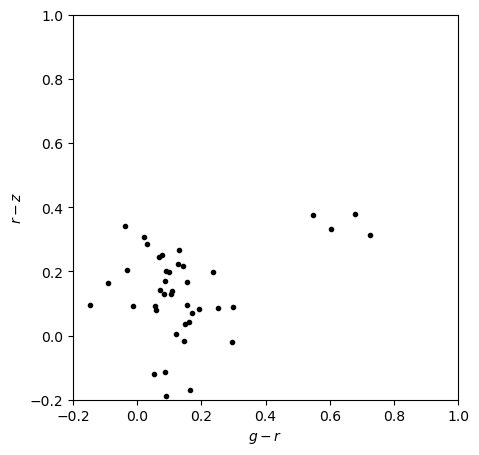

In [28]:
flux_g = np.array([row.Photometry.flux_g for row in q])
flux_r = np.array([row.Photometry.flux_r for row in q])
flux_z = np.array([row.Photometry.flux_z for row in q])
g_minus_r = np.log10(flux_r/flux_g)
r_minus_z = np.log10(flux_z/flux_r)
redshift = np.array([row.Zpix.z for row in q])
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
p = axes.plot(g_minus_r, r_minus_z, 'k.')
foo = axes.set_xlim([-0.2, 1.0])
foo = axes.set_ylim([-0.2, 1.0])
foo = axes.set_aspect('equal')
foo = axes.set_xlabel('$g - r$')
foo = axes.set_ylabel('$r - z$')

#### Exercise

* Create a color-color plot for objects targeted as QSOs, and spectroscopically confirmed as such.

### A More Complicated Join

Let's look at objects that appear on more than one tile. For each of those tiles, how many exposures where there?

In this example, we're using `sqlalchemy.sql.func` to get the equivalent of `COUNT(*)` and a subquery that itself is a multi-table join.

```SQL
SELECT t.nexp, f.tileid, q1.targetid, q1.n_assign FROM fuji.fiberassign AS f
    JOIN (SELECT ff.targetid, COUNT(*) AS n_assign FROM fuji.fiberassign AS ff GROUP BY ff.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN fuji.tile AS t ON f.tileid = t.tileid LIMIT 100;
```

In [29]:
# db.dbSession.rollback()
q1 = db.dbSession.query(db.Fiberassign.targetid, func.count('*').label('n_assign')).group_by(db.Fiberassign.targetid).subquery()
q2 = db.dbSession.query(db.Tile.nexp, db.Fiberassign.tileid, q1.c.targetid, q1.c.n_assign).filter(q1.c.n_assign>2).filter(db.Fiberassign.targetid == q1.c.targetid).filter(db.Tile.tileid == db.Fiberassign.tileid)[:100]

In [30]:
q2

[(1, 278, 933811403620352, 3),
 (4, 279, 933811403620352, 3),
 (2, 280, 933811403620352, 3),
 (1, 113, 934457234161664, 3),
 (2, 114, 934457234161664, 3),
 (1, 117, 934457234161664, 3),
 (2, 385, 934560644726784, 3),
 (1, 388, 934560644726784, 3),
 (1, 436, 934560644726784, 3),
 (1, 486, 1000347531214848, 3),
 (1, 487, 1000347531214848, 3),
 (1, 488, 1000347531214848, 3),
 (1, 86, 1009771901616128, 4),
 (1, 87, 1009771901616128, 4),
 (2, 88, 1009771901616128, 4),
 (2, 89, 1009771901616128, 4),
 (2, 280, 1017422609907712, 3),
 (1, 281, 1017422609907712, 3),
 (1, 472, 1017422609907712, 3),
 (1, 331, 1018270354243585, 3),
 (1, 334, 1018270354243585, 3),
 (1, 478, 1018270354243585, 3),
 (2, 578, 1018296853856257, 3),
 (1, 580, 1018296853856257, 3),
 (1, 581, 1018296853856257, 3),
 (1, 85, 1018553679478786, 4),
 (2, 88, 1018553679478786, 4),
 (2, 89, 1018553679478786, 4),
 (1, 92, 1018553679478786, 4),
 (2, 89, 1018567994638338, 3),
 (1, 90, 1018567994638338, 3),
 (1, 92, 1018567994638338, 

Now let's see what the redshift table thinks are the number of exposures for these objects.

```SQL
SELECT z.* FROM fuji.zpix AS z WHERE z.targetid IN (6432023904256, 6448025174016[, ...]);
```

In [31]:
q3 = db.dbSession.query(db.Zpix).filter(db.Zpix.targetid.in_([row[2] for row in q2])).all()

In [32]:
[(row.coadd_numexp, row.zcat_nspec) for row in q3]

[(3, 1),
 (3, 1),
 (4, 1),
 (3, 1),
 (4, 1),
 (4, 1),
 (3, 1),
 (4, 1),
 (6, 1),
 (4, 1),
 (4, 1),
 (5, 1),
 (3, 1),
 (3, 1),
 (4, 1),
 (4, 1),
 (2, 1),
 (4, 1),
 (4, 1),
 (3, 1),
 (4, 1),
 (3, 1),
 (2, 1),
 (4, 1),
 (3, 1),
 (2, 1),
 (3, 1),
 (7, 1),
 (3, 1),
 (5, 1)]

#### Exercise

* What is the distribution of number of exposures?

## Fly me to the Moon

How does the Moon affect redshifts?  First, let's find exposures that exposures that had the Moon above the horizon.

In [33]:
moon_up = [e.expid for e in db.dbSession.query(db.Exposure).all() if ephem.moon(e.mjd, e.tilera, e.tiledec)[1] > 0]
len(moon_up)

902

In [34]:
moon_up

[90250,
 87505,
 87382,
 87126,
 87128,
 87263,
 87381,
 87259,
 87618,
 79308,
 79309,
 79310,
 79311,
 77579,
 83748,
 83448,
 83166,
 83010,
 83011,
 86514,
 85637,
 86756,
 90247,
 86627,
 86508,
 87124,
 86757,
 87122,
 86987,
 86988,
 87125,
 85636,
 86511,
 87617,
 86509,
 86626,
 83891,
 86993,
 87261,
 87127,
 87262,
 90249,
 86513,
 86755,
 86753,
 86015,
 86013,
 86269,
 86260,
 86264,
 86252,
 86019,
 86256,
 86378,
 86384,
 86388,
 86392,
 86258,
 86254,
 86251,
 86011,
 86017,
 86382,
 86504,
 85635,
 90246,
 86758,
 86625,
 87123,
 87380,
 90245,
 87257,
 87506,
 87129,
 87121,
 90239,
 86986,
 86515,
 85082,
 85502,
 85503,
 90240,
 85628,
 85340,
 87385,
 86619,
 86618,
 87264,
 87384,
 86620,
 86518,
 79576,
 79577,
 74463,
 74462,
 85509,
 85508,
 85507,
 86622,
 86621,
 74829,
 74830,
 74831,
 74832,
 85078,
 86741,
 85189,
 86617,
 86616,
 85196,
 86495,
 85626,
 85075,
 85343,
 85627,
 85624,
 85623,
 85622,
 85621,
 85620,
 82359,
 82495,
 82360,
 82354,
 81859,


So there are a few.  But there is a subtle issue: redshifts are based on *all* exposures, and the exposures are deliberately designed to enforce the bright/dark dichotomy in targeting. There are execptions though: certain LRGs also get targeted in the BGS & MWS, so that's not hard to capture. 

In [35]:
various_lrgs = (desi_mask.LRG | desi_mask.BGS_ANY | desi_mask.MWS_ANY)
various_lrgs

3458764513820540929

```SQL
SELECT z.targetid, z.z, z.zerr, z.zwarn
    FROM fuji.ztile AS z
    JOIN fuji.target AS t ON z.targetphotid = t.id
    JOIN fuji.fiberassign AS f ON t.targetid = f.targetid
    JOIN fuji.exposure AS e ON f.tileid == e.tileid
    WHERE z.spgrp = 'cumulative'
    AND t.desi_target & 3458764513820540929 != 0
    AND e.expid IN (90250, 87505, 87382[...]);
```

In [39]:
q_up = db.dbSession.query(db.Ztile.targetid, db.Ztile.z, db.Ztile.zerr, db.Ztile.zwarn)\
                   .join(db.Target, db.Target.id==db.Ztile.targetphotid)\
                   .join(db.Fiberassign, db.Target.targetid==db.Fiberassign.targetid)\
                   .join(db.Exposure, db.Fiberassign.tileid==db.Exposure.tileid)\
                   .filter(db.Ztile.spgrp=='cumulative')\
                   .filter(db.Target.desi_target.op('&')(various_lrgs) != 0)\
                   .filter(db.Exposure.expid.in_(moon_up)).all()

```SQL
SELECT z.targetid, z.z, z.zerr, z.zwarn
    FROM fuji.ztile AS z
    JOIN fuji.target AS t ON z.targetphotid = t.id
    JOIN fuji.fiberassign AS f ON t.targetid = f.targetid
    JOIN fuji.exposure AS e ON f.tileid == e.tileid
    WHERE z.spgrp = 'cumulative'
    AND t.desi_target & 3458764513820540929 != 0
    AND e.expid NOT IN (90250, 87505, 87382[...]);
```

In [40]:
q_dn = db.dbSession.query(db.Ztile.targetid, db.Ztile.z, db.Ztile.zerr, db.Ztile.zwarn)\
                   .join(db.Target, db.Target.id==db.Ztile.targetphotid)\
                   .join(db.Fiberassign, db.Target.targetid==db.Fiberassign.targetid)\
                   .join(db.Exposure, db.Fiberassign.tileid==db.Exposure.tileid)\
                   .filter(db.Ztile.spgrp=='cumulative')\
                   .filter(db.Target.desi_target.op('&')(various_lrgs) != 0)\
                   .filter(~db.Exposure.expid.in_(moon_up)).all()

Unfortunately however, the database currently only contains cumulative tile redshifts, not per-exposure redshifts, so it's not really meaningful to say whether the Moon was up or not. We'll just call this a work in progress.

In [41]:
q_up

[(39632946390369716, 0.60137884671251, 0.000247502988865207, 4),
 (39632946390369716, 0.60137884671251, 0.000247502988865207, 4),
 (39628261977751793, 1.33387505095087e-05, 3.68759048343979e-05, 0),
 (39628449253426091, 0.218991731767735, 0.00010917375382344, 4),
 (39628454571803639, 0.000124139370446391, 8.23797963265747e-06, 0),
 (39628261977751793, -8.37999762273505e-06, 2.89018744408056e-05, 0),
 (39628261977751793, -1.5036730749278e-05, 2.94795443728668e-05, 0),
 (39628261977751793, -5.64833212900318e-05, 3.89945041118512e-05, 0),
 (39628261977751793, -1.74616736008978e-05, 2.26564096711812e-05, 0),
 (39628261977751793, -7.14180519474188e-05, 3.18378843561538e-05, 0),
 (39628261977751793, -1.70113946972231e-05, 2.93095828450764e-05, 0),
 (39628261977751793, 1.48071207346949e-05, 3.71682943906391e-05, 0),
 (39628261977751793, 1.33387505095087e-05, 3.68759048343979e-05, 0),
 (39628261977751793, -8.37999762273505e-06, 2.89018744408056e-05, 0),
 (39628261977751793, -1.5036730749278e-0

In [42]:
q_dn

[(39628233443902562, 1.21726474212787, 0.000269336185328537, 0),
 (39628233443902562, 1.21995171585, 0.000234690087948392, 0),
 (39628233443902562, 1.21978447144697, 0.000208817909933986, 0),
 (39628233443902562, 1.21895509403062, 0.000156498200417369, 0),
 (39628233443902562, 1.21766609973068, 0.000175919360757108, 0),
 (39628233443902562, 1.21936932940217, 0.000252143169714738, 0),
 (39628233443902562, 1.21715392104211, 0.000170650340998102, 0),
 (39628233443902562, 1.21867329732197, 0.00019885822764141, 0),
 (39628233439710049, -0.000175679569890621, 3.54874612282824e-05, 0),
 (39628233439710049, -0.000275244541187144, 6.03254914447175e-05, 0),
 (39628233439710049, -0.000243730875341778, 3.25239736766197e-05, 0),
 (39628233439710049, -0.000233102613766191, 2.97485854238293e-05, 0),
 (39628233439710049, -0.000190908369119901, 2.77969183969461e-05, 0),
 (39628233439710049, -0.000155791749480724, 2.13857115880492e-05, 0),
 (39628233443902562, 1.21726474212787, 0.000269336185328537, 0),

## Survey Progress

Let's see which nights have data, and count the number of exposures per night.

```SQL
SELECT e.night, COUNT(e.expid) AS n_exp FROM fuji.exposure AS e GROUP BY e.night ORDER BY e.night;
```

In [43]:
q = db.dbSession.query(db.Exposure.night, func.count(db.Exposure.expid).label('n_exp')).group_by(db.Exposure.night).order_by(db.Exposure.night).all()
q

[(20201214, 17),
 (20201215, 23),
 (20201216, 24),
 (20201217, 7),
 (20201218, 27),
 (20201219, 34),
 (20201220, 29),
 (20201221, 46),
 (20201222, 24),
 (20201223, 29),
 (20210101, 33),
 (20210102, 44),
 (20210103, 42),
 (20210105, 37),
 (20210106, 27),
 (20210107, 45),
 (20210108, 25),
 (20210109, 38),
 (20210110, 26),
 (20210111, 25),
 (20210114, 1),
 (20210115, 35),
 (20210116, 39),
 (20210130, 24),
 (20210131, 16),
 (20210201, 7),
 (20210202, 16),
 (20210203, 15),
 (20210204, 9),
 (20210205, 53),
 (20210206, 27),
 (20210208, 36),
 (20210212, 19),
 (20210214, 34),
 (20210215, 11),
 (20210216, 28),
 (20210217, 19),
 (20210218, 25),
 (20210220, 27),
 (20210221, 31),
 (20210222, 16),
 (20210223, 22),
 (20210224, 17),
 (20210228, 7),
 (20210304, 15),
 (20210305, 27),
 (20210306, 36),
 (20210308, 19),
 (20210309, 34),
 (20210313, 5),
 (20210314, 25),
 (20210315, 1),
 (20210316, 14),
 (20210317, 9),
 (20210318, 31),
 (20210319, 43),
 (20210320, 9),
 (20210321, 25),
 (20210322, 25),
 (2021

Observation timestamp for a given night.  Note how we have both MJD and a corresponding `datetime.datetime` object in the database.

```SQL
SELECT e.expid, e.mjd, e.date_obs FROM fuji.exposure AS e WHERE e.night = 20210428 ORDER BY e.expid;
```

In [44]:
q = db.dbSession.query(db.Exposure.expid, db.Exposure.mjd, db.Exposure.date_obs).filter(db.Exposure.night == 20210428).order_by(db.Exposure.expid).all()
q

[(86493, 59333.21675472, datetime.datetime(2021, 4, 29, 5, 12, 7, 607808, tzinfo=datetime.timezone.utc)),
 (86494, 59333.22358025, datetime.datetime(2021, 4, 29, 5, 21, 57, 333600, tzinfo=datetime.timezone.utc)),
 (86495, 59333.2315314, datetime.datetime(2021, 4, 29, 5, 33, 24, 312960, tzinfo=datetime.timezone.utc)),
 (86503, 59333.30986707, datetime.datetime(2021, 4, 29, 7, 26, 12, 514848, tzinfo=datetime.timezone.utc)),
 (86504, 59333.32705906, datetime.datetime(2021, 4, 29, 7, 50, 57, 902784, tzinfo=datetime.timezone.utc)),
 (86505, 59333.33191879, datetime.datetime(2021, 4, 29, 7, 57, 57, 783456, tzinfo=datetime.timezone.utc)),
 (86507, 59333.37990237, datetime.datetime(2021, 4, 29, 9, 7, 3, 564768, tzinfo=datetime.timezone.utc)),
 (86508, 59333.38628676, datetime.datetime(2021, 4, 29, 9, 16, 15, 176064, tzinfo=datetime.timezone.utc)),
 (86509, 59333.39238268, datetime.datetime(2021, 4, 29, 9, 25, 1, 863552, tzinfo=datetime.timezone.utc)),
 (86511, 59333.40257555, datetime.datetime

So, for a given target in the `target` table, when was the observation completed?  In other words, if a target has multiple observations, we want the date of the *last* observation.  First, how many targets are there?

```SQL
SELECT COUNT(*) FROM fuji.target;
```

In [45]:
N_targets = db.dbSession.query(db.Target).count()
N_targets

16460561

Now we look for targets that have observations and find the MJD of the observation.

```SQL
SELECT f.targetid, e.expid, e.mjd FROM fuji.fiberassign AS f
    JOIN (SELECT tt.targetid FROM fuji.target AS tt JOIN fuji.fiberassign AS ff ON tt.targetid = ff.targetid
              JOIN fuji.exposure AS ee ON ff.tileid = ee.tileid GROUP BY tt.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN fuji.exposure AS e ON f.tileid = e.tileid ORDER BY q1.targetid, e.expid;
```

In [46]:
#
# Find all targetids that have observations.
#
q1 = db.dbSession.query(db.Target.targetid).filter(db.Target.targetid == db.Fiberassign.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).group_by(db.Target.targetid).subquery()
#
# Find the exposure times for the targetids that have been observed
#
q2 = db.dbSession.query(db.Fiberassign.targetid, db.Exposure.expid, db.Exposure.mjd).filter(db.Fiberassign.targetid == q1.c.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).order_by(q1.c.targetid, db.Exposure.expid).all()
targetid, expid, mjd = zip(*q2)
targetid = np.array(targetid)
expid = np.array(expid)
mjd = np.array(mjd)
#
# Use the counts to give the *last* observation.
#
unique_targetid, i, j, c = np.unique(targetid, return_index=True, return_inverse=True, return_counts=True)
unique_expid = expid[i + (c-1)]
unique_mjd = mjd[i + (c-1)]

Now we have the targets and the date of last observation.  But it's sorted by `targetid`.

In [47]:
ii = unique_expid.argsort()
unique_targetid, i3, j3, c3 = np.unique(unique_expid[ii], return_index=True, return_inverse=True, return_counts=True)
N_completed = np.cumsum(c3)

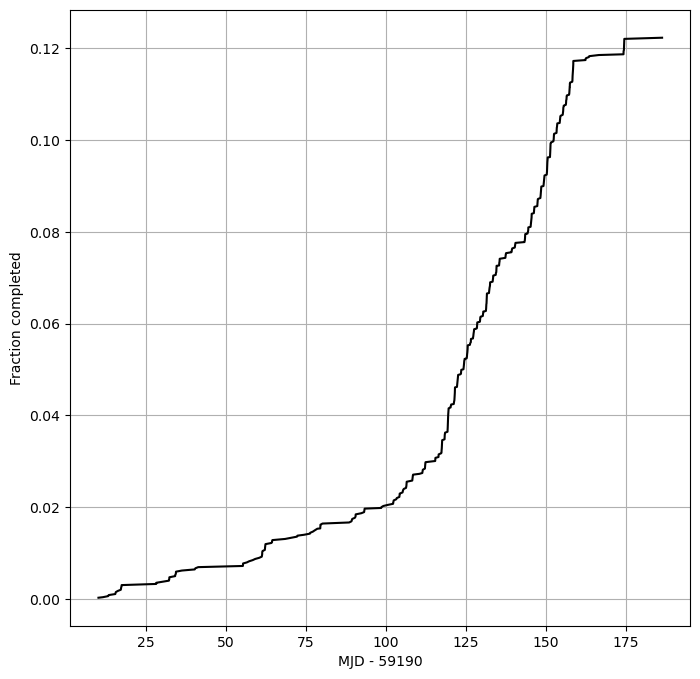

In [48]:
min_mjd = 10*(int(mjd.min())//10)
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
p1 = axes.plot(unique_mjd[ii][i3] - min_mjd, N_completed/N_targets, 'k-')
foo = axes.set_xlabel(f'MJD - {min_mjd:d}')
foo = axes.set_ylabel('Fraction completed')
foo = axes.grid(True)
# foo = axes.legend(loc=1)

### Exercise

* Break down the progress by target class, target bit, etc.

## Using Relationships in SQLAlchemy

Here we demonstrate how table relationships can simplify certain queries. First we grab a single `db.Exposure` object.

```SQL
SELECT * FROM fuji.exposure where expid = 86507;
```

In [49]:
exposure = db.dbSession.query(db.Exposure).filter(db.Exposure.expid == 86507).one()
exposure

Exposure(night=20210428, expid=86507, tileid=401)

How do we get the `db.Frame` objects associated with this exposure?

In [50]:
exposure.frames

[Frame(expid=86507, camera='b0'),
 Frame(expid=86507, camera='b1'),
 Frame(expid=86507, camera='b2'),
 Frame(expid=86507, camera='b3'),
 Frame(expid=86507, camera='b4'),
 Frame(expid=86507, camera='b5'),
 Frame(expid=86507, camera='b6'),
 Frame(expid=86507, camera='b7'),
 Frame(expid=86507, camera='b8'),
 Frame(expid=86507, camera='b9'),
 Frame(expid=86507, camera='r0'),
 Frame(expid=86507, camera='r1'),
 Frame(expid=86507, camera='r2'),
 Frame(expid=86507, camera='r3'),
 Frame(expid=86507, camera='r4'),
 Frame(expid=86507, camera='r5'),
 Frame(expid=86507, camera='r6'),
 Frame(expid=86507, camera='r7'),
 Frame(expid=86507, camera='r8'),
 Frame(expid=86507, camera='r9'),
 Frame(expid=86507, camera='z0'),
 Frame(expid=86507, camera='z1'),
 Frame(expid=86507, camera='z2'),
 Frame(expid=86507, camera='z3'),
 Frame(expid=86507, camera='z4'),
 Frame(expid=86507, camera='z5'),
 Frame(expid=86507, camera='z6'),
 Frame(expid=86507, camera='z7'),
 Frame(expid=86507, camera='z8'),
 Frame(expid=8

What tile is associated with this exposure?

In [51]:
exposure.tile

Tile(tileid=401)

What fiberassignments were made on this tile?

In [52]:
exposure.tile.fiberassign[:20]

[Fiberassign(tileid=401, targetid=2305843019003212516, location=1483),
 Fiberassign(tileid=401, targetid=2305843019003213608, location=1464),
 Fiberassign(tileid=401, targetid=2305843019003212073, location=521),
 Fiberassign(tileid=401, targetid=2305843019003213545, location=520),
 Fiberassign(tileid=401, targetid=2305843019003224230, location=519),
 Fiberassign(tileid=401, targetid=2305843019003217368, location=505),
 Fiberassign(tileid=401, targetid=2305843019003207059, location=1416),
 Fiberassign(tileid=401, targetid=2305843019003208522, location=1418),
 Fiberassign(tileid=401, targetid=2305843019003205573, location=1442),
 Fiberassign(tileid=401, targetid=2305843019003214342, location=1443),
 Fiberassign(tileid=401, targetid=2305843019003213965, location=1420),
 Fiberassign(tileid=401, targetid=2305843019003214124, location=1396),
 Fiberassign(tileid=401, targetid=2305843019003213725, location=1419),
 Fiberassign(tileid=401, targetid=2305843019003215192, location=1395),
 Fiberassi

What redshifts were measured on this tile?

In [53]:
exposure.tile.ztile_redshifts[:20]

[Ztile(targetid=2305843019007400014, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007397295, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007394719, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007399070, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007396417, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007394531, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007398261, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007400147, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007399056, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007397105, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007398534, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=23058

### Exercise

* Rewrite example queries above using relationships wherever possible.

## Using q3c in SQLAlchemy

[q3c](https://github.com/segasai/q3c) ([Koposov & Bartunov 2006](https://ui.adsabs.harvard.edu/abs/2006ASPC..351..735K/abstract)) is a popular library that provides spatial indexing and searching in astronomical databases. Here we'll demonstrate how to access this functionality in SQLAlchemy.  Any database function is accessible with `sqlalchemy.sql.func`.  This is a radial ("cone") search on an arbitrary point in the DESI footprint:

```SQL
SELECT p.*, z.*, q3c_dist(p.ra, p.dec, 180.0, 0.0) AS radial_distance
    FROM fuji.photometry AS p JOIN fuji.zpix AS z ON p.targetid = z.targetid
    WHERE q3c_radial_query(p.ra, p.dec, 180.0, 0.0, 1.0/60.0); -- 1 arcmin
```

In [54]:
q = db.dbSession.query(db.Photometry, db.Zpix, func.q3c_dist(db.Photometry.ra, db.Photometry.dec, 180.0, 0.0).label("radial_distance")).join(db.Zpix).filter(func.q3c_radial_query(db.Photometry.ra, db.Photometry.dec, 180.0, 0.0, 1.0/60.0)).all()  # 1 arcmin
q

[(Photometry(targetid=39627787744581338), Zpix(targetid=39627787744581338, survey='sv3', program='dark'), 0.0155553060060447),
 (Photometry(targetid=39627787744581338), Zpix(targetid=39627787744581338, survey='sv1', program='dark'), 0.0155553060060447),
 (Photometry(targetid=39627787744581040), Zpix(targetid=39627787744581040, survey='sv3', program='bright'), 0.0166239589966163),
 (Photometry(targetid=39627787744581419), Zpix(targetid=39627787744581419, survey='sv3', program='bright'), 0.0162460808451895),
 (Photometry(targetid=39627787744581068), Zpix(targetid=39627787744581068, survey='sv3', program='bright'), 0.0154899710431295),
 (Photometry(targetid=39627787744581408), Zpix(targetid=39627787744581408, survey='sv3', program='bright'), 0.00272573517354215),
 (Photometry(targetid=2305843037487501690), Zpix(targetid=2305843037487501690, survey='sv3', program='backup'), 0.0155599700637323),
 (Photometry(targetid=39627787748769959), Zpix(targetid=39627787748769959, survey='sv3', program

### Exercise

* What spectra are near your favourite object?

## Finding Anomalous Targeting

We are trying to identify objects that appear on multiple tiles that have the same `targetid` and `survey`, but different targeting bits on different tiles. However, in principle, we don't care about cases where the `targetid`, `tileid` only appears as a potential target.

Let's get the set of `targetid` for a particular `survey` and `program` that appear on more than one tile:

```sql
SELECT t.targetid
    FROM fuji.target AS t JOIN fuji.fiberassign AS f ON t.targetid = f.targetid AND t.tileid = f.tileid
    WHERE t.survey = 'sv1' AND t.program = 'dark'
    GROUP BY t.targetid HAVING COUNT(t.tileid) > 1;
```

In [55]:
observed_multiple_tiles = db.dbSession.query(db.Target.targetid).join(db.Fiberassign, and_(db.Target.targetid == db.Fiberassign.targetid, db.Target.tileid == db.Fiberassign.tileid)).filter(db.Target.survey == 'sv1').filter(db.Target.program == 'dark').group_by(db.Target.targetid).having(func.count(db.Target.tileid) > 1)
print(observed_multiple_tiles)

SELECT fuji.target.targetid AS fuji_target_targetid 
FROM fuji.target JOIN fuji.fiberassign ON fuji.target.targetid = fuji.fiberassign.targetid AND fuji.target.tileid = fuji.fiberassign.tileid 
WHERE fuji.target.survey = %(survey_1)s AND fuji.target.program = %(program_1)s GROUP BY fuji.target.targetid 
HAVING count(fuji.target.tileid) > %(count_1)s


We will call the result of this query `observed_multiple_tiles`. Now let's find the distinct pairs of `targetid`, `sv1_desi_target` from this set:

```sql
SELECT DISTINCT targetid, sv1_desi_target
    FROM fuji.target WHERE targetid IN (observed_multiple_tiles) AND survey = 'sv1' AND program = 'dark';
```

In [56]:
distinct_target = db.dbSession.query(db.Target.targetid, db.Target.sv1_desi_target).filter(db.Target.targetid.in_(observed_multiple_tiles)).filter(db.Target.survey == 'sv1').filter(db.Target.program == 'dark').distinct().subquery()
print(distinct_target)

SELECT DISTINCT fuji.target.targetid, fuji.target.sv1_desi_target 
FROM fuji.target 
WHERE fuji.target.targetid IN (SELECT fuji.target.targetid 
FROM fuji.target JOIN fuji.fiberassign ON fuji.target.targetid = fuji.fiberassign.targetid AND fuji.target.tileid = fuji.fiberassign.tileid 
WHERE fuji.target.survey = :survey_1 AND fuji.target.program = :program_1 GROUP BY fuji.target.targetid 
HAVING count(fuji.target.tileid) > :count_1) AND fuji.target.survey = :survey_2 AND fuji.target.program = :program_2


We will call the result of this query `distinct_target`.  Next we eliminate cases where targetid only appears once in distinct_target:

```sql
SELECT targetid
    FROM (distinct_target) AS dt GROUP BY targetid HAVING COUNT(sv1_desi_target) > 1;
```

In [57]:
multiple_target = db.dbSession.query(distinct_target.c.targetid).group_by(distinct_target.c.targetid).having(func.count(distinct_target.c.sv1_desi_target) > 1)
print(multiple_target)
multiple_target.count()

SELECT anon_1.targetid AS anon_1_targetid 
FROM (SELECT DISTINCT fuji.target.targetid AS targetid, fuji.target.sv1_desi_target AS sv1_desi_target 
FROM fuji.target 
WHERE fuji.target.targetid IN (SELECT fuji.target.targetid 
FROM fuji.target JOIN fuji.fiberassign ON fuji.target.targetid = fuji.fiberassign.targetid AND fuji.target.tileid = fuji.fiberassign.tileid 
WHERE fuji.target.survey = %(survey_1)s AND fuji.target.program = %(program_1)s GROUP BY fuji.target.targetid 
HAVING count(fuji.target.tileid) > %(count_1)s) AND fuji.target.survey = %(survey_2)s AND fuji.target.program = %(program_2)s) AS anon_1 GROUP BY anon_1.targetid 
HAVING count(anon_1.sv1_desi_target) > %(count_2)s


79

We will call the result of this query `multiple_target`. If we only want to know the number of objects, we're actually done at this stage: the answer is the number of rows of `multiple_target`.  But we can easily get more complete information:

```sql
SELECT t.targetid, t.survey, t.tileid, t.program, t.obsconditions, t.numobs_init, t.priority_init, t.subpriority, t.sv1_desi_target, t.sv1_bgs_target, t.sv1_mws_target, t.sv1_scnd_target, p.ra, p.dec
    FROM fuji.target AS t JOIN fuji.photometry AS p ON t.targetid = p.targetid
    WHERE t.survey = 'sv1' AND t.program = 'dark' AND t.targetid IN (multiple_target) ORDER BY t.targetid, t.tileid;
```

In [58]:
q = db.dbSession.query(db.Target.targetid, db.Target.survey, db.Target.tileid, db.Target.program, db.Target.obsconditions, db.Target.numobs_init, db.Target.priority_init, db.Target.subpriority, db.Target.sv1_desi_target, db.Target.sv1_bgs_target, db.Target.sv1_mws_target, db.Target.sv1_scnd_target, db.Photometry.ra, db.Photometry.dec).join(db.Photometry).filter(db.Target.survey == 'sv1').filter(db.Target.program == 'dark').filter(db.Target.targetid.in_(multiple_target)).order_by(db.Target.targetid, db.Target.tileid)
print(q)
q.all()

SELECT fuji.target.targetid AS fuji_target_targetid, fuji.target.survey AS fuji_target_survey, fuji.target.tileid AS fuji_target_tileid, fuji.target.program AS fuji_target_program, fuji.target.obsconditions AS fuji_target_obsconditions, fuji.target.numobs_init AS fuji_target_numobs_init, fuji.target.priority_init AS fuji_target_priority_init, fuji.target.subpriority AS fuji_target_subpriority, fuji.target.sv1_desi_target AS fuji_target_sv1_desi_target, fuji.target.sv1_bgs_target AS fuji_target_sv1_bgs_target, fuji.target.sv1_mws_target AS fuji_target_sv1_mws_target, fuji.target.sv1_scnd_target AS fuji_target_sv1_scnd_target, fuji.photometry.ra AS fuji_photometry_ra, fuji.photometry.dec AS fuji_photometry_dec 
FROM fuji.target JOIN fuji.photometry ON fuji.photometry.targetid = fuji.target.targetid 
WHERE fuji.target.survey = %(survey_1)s AND fuji.target.program = %(program_1)s AND fuji.target.targetid IN (SELECT anon_1.targetid 
FROM (SELECT DISTINCT fuji.target.targetid AS targetid, fu

[(39628500923060195, 'sv1', 80690, 'dark', 3, 8, 3400, 0.983122124704334, 54047318697103110, 0, 0, 0, 134.200248289668, 31.0107996972334),
 (39628500923060195, 'sv1', 80691, 'dark', 3, 8, 3400, 0.983122124704334, 4665733337124491014, 0, 0, 34359869440, 134.200248289668, 31.0107996972334),
 (39628500939834932, 'sv1', 80690, 'dark', 7, 1, 1050, 0.906294111915661, 2305843026393563136, 0, 81920, 0, 135.224452209346, 31.005952222602),
 (39628500939834932, 'sv1', 80691, 'dark', 1, 100, 2998, 0.906294111915661, 6917529044820951040, 0, 81922, 131072, 135.224452209346, 31.005952222602),
 (39628506119798938, 'sv1', 80690, 'dark', 7, 1, 1100, 0.678005736634616, 2305843052163366912, 0, 33, 0, 135.081459477579, 31.2520285431903),
 (39628506119798938, 'sv1', 80691, 'dark', 7, 100, 2995, 0.678005736634616, 6917529070590754816, 0, 33, 206158430208, 135.081459477579, 31.2520285431903),
 (39628506119800881, 'sv1', 80690, 'dark', 7, 1, 1050, 0.378658012604629, 2305843026393563136, 0, 81920, 0, 135.184801

Now let's find corresponding rows in the `zpix` table. We can reuse the `multiple_target` query from above.

```sql
SELECT id, targetid, z, zwarn
    FROM fuji.zpix
    WHERE targetid IN (multiple_targets) AND survey = 'sv1' AND program = 'dark';
```

In [61]:
multiple_zpix = db.dbSession.query(db.Zpix).filter(db.Zpix.targetid.in_(multiple_target)).filter(db.Zpix.survey == 'sv1').filter(db.Zpix.program == 'dark')
print(multiple_zpix)
multiple_zpix.count()

SELECT fuji.zpix.id AS fuji_zpix_id, fuji.zpix.targetid AS fuji_zpix_targetid, fuji.zpix.survey AS fuji_zpix_survey, fuji.zpix.program AS fuji_zpix_program, fuji.zpix.spgrp AS fuji_zpix_spgrp, fuji.zpix.spgrpval AS fuji_zpix_spgrpval, fuji.zpix.healpix AS fuji_zpix_healpix, fuji.zpix.z AS fuji_zpix_z, fuji.zpix.zerr AS fuji_zpix_zerr, fuji.zpix.zwarn AS fuji_zpix_zwarn, fuji.zpix.chi2 AS fuji_zpix_chi2, fuji.zpix.coeff_0 AS fuji_zpix_coeff_0, fuji.zpix.coeff_1 AS fuji_zpix_coeff_1, fuji.zpix.coeff_2 AS fuji_zpix_coeff_2, fuji.zpix.coeff_3 AS fuji_zpix_coeff_3, fuji.zpix.coeff_4 AS fuji_zpix_coeff_4, fuji.zpix.coeff_5 AS fuji_zpix_coeff_5, fuji.zpix.coeff_6 AS fuji_zpix_coeff_6, fuji.zpix.coeff_7 AS fuji_zpix_coeff_7, fuji.zpix.coeff_8 AS fuji_zpix_coeff_8, fuji.zpix.coeff_9 AS fuji_zpix_coeff_9, fuji.zpix.npixels AS fuji_zpix_npixels, fuji.zpix.spectype AS fuji_zpix_spectype, fuji.zpix.subtype AS fuji_zpix_subtype, fuji.zpix.ncoeff AS fuji_zpix_ncoeff, fuji.zpix.deltachi2 AS fuji_zpix_

79

### Correcting Anomalous Targeting

Now that we know exactly which objects are anomalous, we can try to fix their targeting bits. We want to take the bitwise `OR` of the targeting bits for these objects. We can reuse objects returned by the `multiple_target` query above.  There are a lot of targeting bits, so it's easier to generate the full list programmatically. We're doing metaprogramming!

```sql
SELECT t.targetid, BIT_OR(t.cmx_target) AS cmx_target, BIT_OR(desi_target) AS desi_target, ...
    FROM fuji.target AS t WHERE t.targetid IN (multiple_target) AND t.survey = 'sv1' AND t.program = 'dark' GROUP BY t.targetid;
```

In [85]:
import itertools
table = 'zpix'
surveys = ('', 'sv1', 'sv2', 'sv3')
programs = ('desi', 'bgs', 'mws', 'scnd')
masks = ['cmx_target'] + [('_'.join(p) if p[0] else p[1]) + '_target'
                          for p in itertools.product(surveys, programs)]
inner_columns = ['targetid', 'survey', 'program'] + masks

print("SELECT t.targetid, " + 
      ', '.join([f"BIT_OR(t.{m}) AS {m}" for m in masks]) +
      f" FROM {specprod}.target AS t WHERE t.targetid IN (multiple_target) AND t.survey = 'sv1' AND t.program = 'dark' GROUP BY t.targetid;")

print("db.dbSession.query(db.Target.targetid, " +
      ', '.join([f"func.bit_or(db.Target.{m}).label('{m}')" for m in masks]) +
      ").filter(db.Target.targetid.in_(multiple_target)).filter(db.Target.survey == 'sv1').filter(db.Target.program == 'dark').group_by(db.Target.targetid)")

# inner_select = ("SELECT " +
#                 ', '.join([f"t.{c}" for c in inner_columns]) +
#                 f" FROM {specprod}.target AS t JOIN {specprod}.fiberassign AS f ON (t.targetid = f.targetid AND t.tileid = f.tileid)")
# print(inner_select)
# outer_select = ("SELECT z.id, " +
#                 ', '.join([f"BIT_OR(tgt.{m}) AS {m}" for m in masks]) +
#                 f" FROM {specprod}.{table} AS z JOIN ({inner_select}) AS tgt ON (z.targetid=tgt.targetid AND z.survey=tgt.survey AND z.program=tgt.program) GROUP BY z.id")
# print(outer_select)
# update = (f"UPDATE {specprod}.{table} AS z1 SET " +
#           ', '.join([f"{m} = z0.{m}" for m in masks]) +
#           f" FROM ({outer_select}) AS z0 WHERE z1.id = z0.id;")
# print(update)

SELECT t.targetid, BIT_OR(t.cmx_target) AS cmx_target, BIT_OR(t.desi_target) AS desi_target, BIT_OR(t.bgs_target) AS bgs_target, BIT_OR(t.mws_target) AS mws_target, BIT_OR(t.scnd_target) AS scnd_target, BIT_OR(t.sv1_desi_target) AS sv1_desi_target, BIT_OR(t.sv1_bgs_target) AS sv1_bgs_target, BIT_OR(t.sv1_mws_target) AS sv1_mws_target, BIT_OR(t.sv1_scnd_target) AS sv1_scnd_target, BIT_OR(t.sv2_desi_target) AS sv2_desi_target, BIT_OR(t.sv2_bgs_target) AS sv2_bgs_target, BIT_OR(t.sv2_mws_target) AS sv2_mws_target, BIT_OR(t.sv2_scnd_target) AS sv2_scnd_target, BIT_OR(t.sv3_desi_target) AS sv3_desi_target, BIT_OR(t.sv3_bgs_target) AS sv3_bgs_target, BIT_OR(t.sv3_mws_target) AS sv3_mws_target, BIT_OR(t.sv3_scnd_target) AS sv3_scnd_target FROM fuji.target AS t WHERE t.targetid IN (multiple_target) AND t.survey = 'sv1' AND t.program = 'dark' GROUP BY t.targetid;
db.dbSession.query(db.Target.targetid, func.bit_or(db.Target.cmx_target).label('cmx_target'), func.bit_or(db.Target.desi_target).labe

In [91]:
multiple_target_or = db.dbSession.query(db.Target.targetid, func.bit_or(db.Target.cmx_target).label('cmx_target'), func.bit_or(db.Target.desi_target).label('desi_target'), func.bit_or(db.Target.bgs_target).label('bgs_target'), func.bit_or(db.Target.mws_target).label('mws_target'), func.bit_or(db.Target.scnd_target).label('scnd_target'), func.bit_or(db.Target.sv1_desi_target).label('sv1_desi_target'), func.bit_or(db.Target.sv1_bgs_target).label('sv1_bgs_target'), func.bit_or(db.Target.sv1_mws_target).label('sv1_mws_target'), func.bit_or(db.Target.sv1_scnd_target).label('sv1_scnd_target'), func.bit_or(db.Target.sv2_desi_target).label('sv2_desi_target'), func.bit_or(db.Target.sv2_bgs_target).label('sv2_bgs_target'), func.bit_or(db.Target.sv2_mws_target).label('sv2_mws_target'), func.bit_or(db.Target.sv2_scnd_target).label('sv2_scnd_target'), func.bit_or(db.Target.sv3_desi_target).label('sv3_desi_target'), func.bit_or(db.Target.sv3_bgs_target).label('sv3_bgs_target'), func.bit_or(db.Target.sv3_mws_target).label('sv3_mws_target'), func.bit_or(db.Target.sv3_scnd_target).label('sv3_scnd_target')).filter(db.Target.targetid.in_(multiple_target)).filter(db.Target.survey == 'sv1').filter(db.Target.program == 'dark').group_by(db.Target.targetid)

In [92]:
print(multiple_target_or)
multiple_target_or.count()

SELECT fuji.target.targetid AS fuji_target_targetid, bit_or(fuji.target.cmx_target) AS cmx_target, bit_or(fuji.target.desi_target) AS desi_target, bit_or(fuji.target.bgs_target) AS bgs_target, bit_or(fuji.target.mws_target) AS mws_target, bit_or(fuji.target.scnd_target) AS scnd_target, bit_or(fuji.target.sv1_desi_target) AS sv1_desi_target, bit_or(fuji.target.sv1_bgs_target) AS sv1_bgs_target, bit_or(fuji.target.sv1_mws_target) AS sv1_mws_target, bit_or(fuji.target.sv1_scnd_target) AS sv1_scnd_target, bit_or(fuji.target.sv2_desi_target) AS sv2_desi_target, bit_or(fuji.target.sv2_bgs_target) AS sv2_bgs_target, bit_or(fuji.target.sv2_mws_target) AS sv2_mws_target, bit_or(fuji.target.sv2_scnd_target) AS sv2_scnd_target, bit_or(fuji.target.sv3_desi_target) AS sv3_desi_target, bit_or(fuji.target.sv3_bgs_target) AS sv3_bgs_target, bit_or(fuji.target.sv3_mws_target) AS sv3_mws_target, bit_or(fuji.target.sv3_scnd_target) AS sv3_scnd_target 
FROM fuji.target 
WHERE fuji.target.targetid IN (SELE

79

There are a small number of these, so we can just loop over each one, ensuring that only one row in the `zpix` table is updated at a time.

In [110]:
from sqlalchemy.exc import ProgrammingError
for row in multiple_target_or.all():
    zpix_match = db.dbSession.query(db.Zpix).filter(db.Zpix.targetid == row.targetid).filter(db.Zpix.survey == 'sv1').filter(db.Zpix.program == 'dark')
    print(zpix_match)
    try:
        zpix_update = db.dbSession.query(db.Zpix).filter(db.Zpix.targetid == row.targetid).filter(db.Zpix.survey == 'sv1').filter(db.Zpix.program == 'dark').update({db.Zpix.z: row.cmx_target}).compile()
    except ProgrammingError as e:
        print(e)
        db.dbSession.rollback()
    # print(zpix_match.count())

SELECT fuji.zpix.id AS fuji_zpix_id, fuji.zpix.targetid AS fuji_zpix_targetid, fuji.zpix.survey AS fuji_zpix_survey, fuji.zpix.program AS fuji_zpix_program, fuji.zpix.spgrp AS fuji_zpix_spgrp, fuji.zpix.spgrpval AS fuji_zpix_spgrpval, fuji.zpix.healpix AS fuji_zpix_healpix, fuji.zpix.z AS fuji_zpix_z, fuji.zpix.zerr AS fuji_zpix_zerr, fuji.zpix.zwarn AS fuji_zpix_zwarn, fuji.zpix.chi2 AS fuji_zpix_chi2, fuji.zpix.coeff_0 AS fuji_zpix_coeff_0, fuji.zpix.coeff_1 AS fuji_zpix_coeff_1, fuji.zpix.coeff_2 AS fuji_zpix_coeff_2, fuji.zpix.coeff_3 AS fuji_zpix_coeff_3, fuji.zpix.coeff_4 AS fuji_zpix_coeff_4, fuji.zpix.coeff_5 AS fuji_zpix_coeff_5, fuji.zpix.coeff_6 AS fuji_zpix_coeff_6, fuji.zpix.coeff_7 AS fuji_zpix_coeff_7, fuji.zpix.coeff_8 AS fuji_zpix_coeff_8, fuji.zpix.coeff_9 AS fuji_zpix_coeff_9, fuji.zpix.npixels AS fuji_zpix_npixels, fuji.zpix.spectype AS fuji_zpix_spectype, fuji.zpix.subtype AS fuji_zpix_subtype, fuji.zpix.ncoeff AS fuji_zpix_ncoeff, fuji.zpix.deltachi2 AS fuji_zpix_

In [109]:
db.dbSession.rollback()